In [1]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

# 下面的分割方法已经弃用

In [2]:
def split_off_dataset(off: pd.DataFrame, space=pd.to_timedelta(0), time_ranges=None):
    """
    滑动窗口分割线下的数据
    :param space: 时间间隔，特征区间之后时间间隔后的一个月作为标签区间，默认为 0
    :param off: 线下数据集
    :param time_ranges: kv，表示特征区间
    :return: 两个列表，特征区间和标签区间，标签区间为特征区间结束间隔space后的一个月
    """
    print("====== offline train set info ======")
    print(off.info())
    print()
    label_len = pd.to_timedelta(30, unit='D') # 三十天
    _feats = []
    _labels = []
    for k, v in time_ranges.items():
        time_range = pd.date_range(k, k+v)
        _feats.append(off[off['Date_received'].isin(time_range) |  # 领券日期在 time_range 内
                          ((off['Coupon_id'] == 0) & off['Date'].isin(time_range))]) # 在 time_range 内直接消费
        print(f'offline features time range {k} : {k+v}, size {len(_feats[len(_feats)-1])}')
        time_range = pd.date_range(k+v+space+pd.to_timedelta(1, 'D'), k+v+space+label_len)
        _labels.append(off[off['Date_received'].isin(time_range)]) # 训练用的标签集合，标签集合不需要采样直接消费的
        print(f'labels time range {k+v+space+pd.to_timedelta(1, "D")} : {k+v+space+label_len},'
              f' size {len(_labels[len(_labels)-1])}')
    del time_range
    print(f'total offline features size {sum(map(lambda x: len(x), _feats))}')
    print(f'total offline labels size {sum(map(lambda x: len(x), _labels))}')
    return _feats, _labels

In [3]:
def split_on_dataset(on: pd.DataFrame, time_ranges=None):
    print("====== online train set info ======")
    print(on.info())
    print()
    _feats = []
    for k, v in time_ranges.items():
        time_range = pd.date_range(k, k+v)
        _feats.append(on[on['Date_received'].isin(time_range) |  # 领券日期在 time_range 内
                        ((on['Coupon_id'] == 0) & on['Date'].isin(time_range))])  # 在 time_range 内直接消费或者点击
    del time_range
    print(f'total online features size {sum(map(lambda x: len(x), _feats))}')
    return _feats

In [4]:
def split_dataset(off: pd.DataFrame, on: pd.DataFrame, space=pd.to_timedelta(0), time_ranges=None):
    _feats_off, _labels = split_off_dataset(off=off, space=space, time_ranges=time_ranges)
    _feats_on = split_on_dataset(on=on, time_ranges=time_ranges)
    return _feats_off, _feats_on, _labels

In [5]:
off_train = pd.read_csv('./dataset_cleaned/ccf_off_train.csv', parse_dates=['Date_received', 'Date'])
on_feat = pd.read_csv('./dataset_cleaned/ccf_on_train.csv', parse_dates=['Date_received', 'Date'])
test = pd.read_csv('./dataset_cleaned/ccf_off_test.csv', parse_dates=['Date_received'])

<AxesSubplot:xlabel='month'>

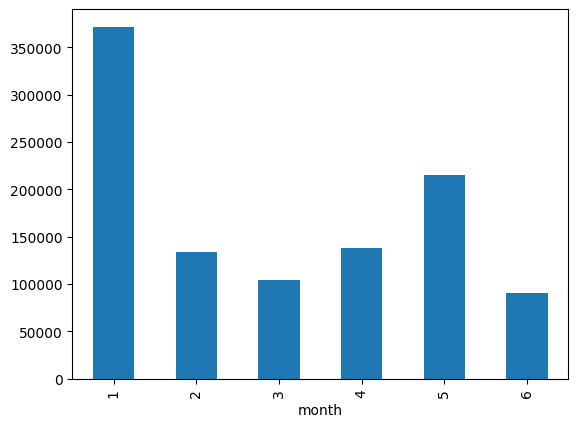

In [49]:
tmp = off_train.groupby('Date_received').size().reset_index(name='cnt')
tmp = pd.DataFrame(tmp).iloc[1:, :]
tmp['month'] = tmp.Date_received.dt.month
tmp.groupby('month').cnt.sum().plot(kind='bar')

In [73]:
pd.date_range('20160101', periods=90)

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20',
               '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29', '2016-01-30', '2016-01-31', '2016-02-01',
               '2016-02-02', '2016-02-03', '2016-02-04', '2016-02-05',
               '2016-02-06', '2016-02-07', '2016-02-08', '2016-02-09',
               '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13',
               '2016-02-14', '2016-02-15', '2016-02-16', '2016-02-17',
               '2016-02-18', '2016-02-19', '2016-02-20', '2016-02-21',
               '2016-02-22', '2016-02-23', '2016-02-24', '2016-02-25',
      

In [7]:
off_train.Date.describe()

count                 1754884
unique                    183
top       1970-01-01 00:00:00
freq                   977900
first     1970-01-01 00:00:00
last      2016-06-30 00:00:00
Name: Date, dtype: object

In [8]:
on_feat.Date_received.describe()

count                11429826
unique                    168
top       1970-01-01 00:00:00
freq                 10689015
first     1970-01-01 00:00:00
last      2016-06-15 00:00:00
Name: Date_received, dtype: object

In [9]:
on_feat.Date.describe()

count                11429826
unique                    183
top       1970-01-01 00:00:00
freq                   655898
first     1970-01-01 00:00:00
last      2016-06-30 00:00:00
Name: Date, dtype: object

In [10]:
test.Date_received.describe()

count                  113640
unique                     31
top       2016-07-03 00:00:00
freq                     5491
first     2016-07-01 00:00:00
last      2016-07-31 00:00:00
Name: Date_received, dtype: object

In [28]:
feats_off, feats_on, labels = split_dataset(off_train, on_feat, time_ranges={
                                      pd.to_datetime('20160101'): pd.to_timedelta(75, unit='D'), # 4月
                                      pd.to_datetime('20160201'): pd.to_timedelta(75, unit='D'), # 5月
                                      pd.to_datetime('20160301'): pd.to_timedelta(75, unit='D'), # 6月
                                  })

====== offline train set info ======
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 16 columns):
 #   Column            Dtype         
---  ------            -----         
 0   User_id           int64         
 1   Merchant_id       int64         
 2   Coupon_id         int64         
 3   Discount_rate     object        
 4   Distance          int64         
 5   Date_received     datetime64[ns]
 6   Date              datetime64[ns]
 7   normal_consume    int64         
 8   coupon_consume    int64         
 9   no_consume        int64         
 10  no_distance       int64         
 11  is_full_discount  int64         
 12  discount_x        int64         
 13  discount_y        int64         
 14  discount_rate     float64       
 15  discount_type     int64         
dtypes: datetime64[ns](2), float64(1), int64(12), object(1)
memory usage: 214.2+ MB
None

offline features time range 2016-01-01 00:00:00 : 2016-03-16 00:00:00, size 

In [33]:
feats_off[2]

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,normal_consume,coupon_consume,no_consume,no_distance,is_full_discount,discount_x,discount_y,discount_rate,discount_type
3,1439408,2632,1078,20:1,0,2016-03-19,1970-01-01,0,0,1,0,1,20,1,0.950000,14
7,1832624,3381,7610,200:20,0,2016-04-29,1970-01-01,0,0,1,0,1,200,20,0.900000,12
18,163606,1569,5054,200:30,10,2016-04-21,1970-01-01,0,0,1,0,1,200,30,0.850000,10
20,94107,3381,7610,200:20,2,2016-04-12,1970-01-01,0,0,1,0,1,200,20,0.900000,12
21,253750,8390,0,1.0,0,1970-01-01,2016-03-27,1,0,0,0,0,-1,-1,1.000000,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754877,212662,3021,3739,30:1,6,2016-05-04,2016-05-08,0,1,0,0,1,30,1,0.966667,15
1754878,212662,2934,5686,30:5,2,2016-03-21,2016-03-22,0,1,0,0,1,30,5,0.833333,9
1754879,212662,3532,0,1.0,1,1970-01-01,2016-03-22,1,0,0,0,0,-1,-1,1.000000,19
1754880,212662,3021,3739,30:1,6,2016-05-08,2016-06-02,0,1,0,0,1,30,1,0.966667,15


In [34]:
feats_on[0]

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,coupon_consume,fixed_consume,normal_consume,no_consume,is_full_discount,discount_x,discount_y,discount_rate,discount_type
10,14336199,38810,0,0,1.0,1970-01-01,2016-01-26,0,0,0,0,0,-1,-1,1.0,31
11,14336199,38810,0,0,1.0,1970-01-01,2016-01-26,0,0,0,0,0,-1,-1,1.0,31
12,14336199,38810,0,0,1.0,1970-01-01,2016-01-26,0,0,0,0,0,-1,-1,1.0,31
13,14336199,38810,0,0,1.0,1970-01-01,2016-01-26,0,0,0,0,0,-1,-1,1.0,31
14,14336199,18907,0,0,1.0,1970-01-01,2016-01-27,0,0,0,0,0,-1,-1,1.0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11429775,12286899,58515,0,0,1.0,1970-01-01,2016-01-28,0,0,0,0,0,-1,-1,1.0,31
11429781,12389331,52415,0,0,1.0,1970-01-01,2016-01-26,0,0,0,0,0,-1,-1,1.0,31
11429782,12389331,18212,0,0,1.0,1970-01-01,2016-01-28,0,0,0,0,0,-1,-1,1.0,31
11429789,12985299,43413,0,0,1.0,1970-01-01,2016-03-07,0,0,0,0,0,-1,-1,1.0,31


In [36]:
labels[0]

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,normal_consume,coupon_consume,no_consume,no_distance,is_full_discount,discount_x,discount_y,discount_rate,discount_type
3,1439408,2632,1078,20:1,0,2016-03-19,1970-01-01,0,0,1,0,1,20,1,0.950000,14
20,94107,3381,7610,200:20,2,2016-04-12,1970-01-01,0,0,1,0,1,200,20,0.900000,12
23,253750,8390,7531,20:5,0,2016-03-27,1970-01-01,0,0,1,0,1,20,5,0.750000,7
38,2881376,8390,7531,20:5,0,2016-03-21,2016-03-29,0,1,0,0,1,20,5,0.750000,7
44,4061024,7555,9871,30:5,10,2016-04-09,1970-01-01,0,0,1,0,1,30,5,0.833333,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754825,261622,3381,7610,200:20,1,2016-04-07,1970-01-01,0,0,1,0,1,200,20,0.900000,12
1754869,188086,6568,4723,30:1,0,2016-04-15,1970-01-01,0,0,1,0,1,30,1,0.966667,15
1754873,212662,2934,5686,30:5,2,2016-03-21,2016-03-30,0,1,0,0,1,30,5,0.833333,9
1754876,212662,3532,5267,30:5,1,2016-03-22,1970-01-01,0,0,1,0,1,30,5,0.833333,9


In [37]:
for i in range(3):
    feats_off[i].to_csv(f'./dataset_split/feat_off_{i}.csv', index=False)
    feats_on[i].to_csv(f'./dataset_split/feat_on_{i}.csv', index=False)
    labels[i].to_csv(f'./dataset_split/label_{i}.csv', index=False)

In [4]:
test_set = pd.read_csv('./dataset_cleaned/ccf_off_test.csv', parse_dates=['Date_received'])
test_set

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,no_distance,is_full_discount,discount_x,discount_y,discount_rate,discount_type
0,4129537,450,9983,30:5,1,2016-07-12,0,1,30,5,0.833333,7
1,6949378,1300,3429,30:5,-1,2016-07-06,1,1,30,5,0.833333,7
2,2166529,7113,6928,200:20,5,2016-07-27,0,1,200,20,0.900000,10
3,2166529,7113,1808,100:10,5,2016-07-27,0,1,100,10,0.900000,10
4,6172162,7605,6500,30:1,2,2016-07-08,0,1,30,1,0.966667,14
...,...,...,...,...,...,...,...,...,...,...,...,...
113635,5828093,5717,10418,30:5,10,2016-07-16,0,1,30,5,0.833333,7
113636,6626813,1699,7595,30:1,-1,2016-07-07,1,1,30,1,0.966667,14
113637,6626813,7321,7590,50:5,-1,2016-07-12,1,1,50,5,0.900000,10
113638,4547069,760,13602,30:5,0,2016-07-17,0,1,30,5,0.833333,7


In [8]:
test_feat_range = pd.date_range(pd.to_datetime('20160402'), periods=75)

In [11]:
test_off_feat = off_train[off_train['Date_received'].isin(test_feat_range) |  # 领券日期在 time_range 内
                          ((off_train['Coupon_id'] == 0) & off_train['Date'].isin(test_feat_range))]

In [12]:
test_on_feat = on_feat[on_feat['Date_received'].isin(test_feat_range) |  # 领券日期在 time_range 内
                        ((on_feat['Coupon_id'] == 0) & on_feat['Date'].isin(test_feat_range))]

In [15]:
test_off_feat.to_csv('./dataset_split/feat_off_test.csv')
test_on_feat.to_csv('./dataset_split/feat_on_test.csv')

# 上面的分割方法已经弃用

In [1]:
import pandas as pd

In [2]:
L_1_range = pd.date_range(start='20160516', end='20160615')    # 标签集1

F_1_1_range = pd.date_range(start='20160201', end='20160430')  # 特征集1-1
F_1_2_range = pd.date_range(start='20160501', end='20160515')  # 特征集1-2
L_1_range.size, F_1_1_range.size, F_1_2_range.size

(31, 90, 15)

In [3]:
L_2_range = pd.date_range(start='20160415', end='20160515')    # 标签集2

F_2_1_range = pd.date_range(start='20160101', end='20160330')  # 特征集2-1
F_2_2_range =pd.date_range(start='20160331', end='20160414')   # 特征集2-1

L_2_range.size, F_2_1_range.size, F_2_2_range.size

(31, 90, 15)

In [4]:
L_T_range = pd.date_range(start='20160701', end='20160731')    # 测试集

F_T_1_range = pd.date_range(start='20160318', end='20160615')  # 测试特征集1
F_T_2_range = pd.date_range(start='20160616', end='20160630')  # 测试特征集2

L_T_range.size, F_T_1_range.size, F_T_2_range.size

(31, 90, 15)

In [5]:
off_train_csv = pd.read_csv('./dataset_cleaned/ccf_off_train.csv', parse_dates=['Date_received', 'Date'])
on_train_csv = pd.read_csv('./dataset_cleaned/ccf_on_train.csv', parse_dates=['Date_received', 'Date'])

In [6]:
F_1_1 = on_train_csv[on_train_csv.Date_received.isin(F_1_1_range) | on_train_csv.Date.isin(F_1_1_range)]
F_1_1.to_csv('./dataset_split/feat_1_1_on.csv', index=False)

In [7]:
F_1_2 = on_train_csv[on_train_csv.Date.isin(F_1_2_range)]
F_1_2.to_csv('./dataset_split/feat_1_2_on.csv', index=False)

In [8]:
# L_2 = off_train_csv[off_train_csv.Date_received.isin(L_2_range)]
# L_2.to_csv('./dataset_split/label_2.csv', index=False)

In [9]:
F_2_1 = on_train_csv[on_train_csv.Date_received.isin(F_2_1_range) | on_train_csv.Date.isin(F_2_1_range)]
F_2_1.to_csv('./dataset_split/feat_2_1_on.csv', index=False)

In [10]:
F_2_2 = on_train_csv[on_train_csv.Date.isin(F_2_2_range)]
F_2_2.to_csv('./dataset_split/feat_2_2_on.csv', index=False)

In [9]:
F_T_1 = on_train_csv[on_train_csv.Date_received.isin(F_T_1_range) | on_train_csv.Date.isin(F_T_1_range)]
F_T_1.to_csv('./dataset_split/feat_test_1_on.csv')

In [10]:
F_T_2 = on_train_csv[on_train_csv.Date.isin(F_T_2_range)]
F_T_2.to_csv('./dataset_split/feat_test_2_on.csv')

In [11]:
F_T_2

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,coupon_consume,fixed_consume,normal_consume,no_consume,is_click,is_full_discount,discount_x,discount_y,discount_rate,discount_type
2,14336199,18907,0,0,1.0,1970-01-01,2016-06-18,0,0,0,0,1,0,-1,-1,1.0,31
3,14336199,18907,0,0,1.0,1970-01-01,2016-06-18,0,0,0,0,1,0,-1,-1,1.0,31
4,14336199,18907,0,0,1.0,1970-01-01,2016-06-18,0,0,0,0,1,0,-1,-1,1.0,31
5,14336199,18907,0,0,1.0,1970-01-01,2016-06-18,0,0,0,0,1,0,-1,-1,1.0,31
6,14336199,18907,0,0,1.0,1970-01-01,2016-06-18,0,0,0,0,1,0,-1,-1,1.0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11429783,12389331,18907,0,0,1.0,1970-01-01,2016-06-23,0,0,0,0,1,0,-1,-1,1.0,31
11429788,12389331,18907,0,0,1.0,1970-01-01,2016-06-17,0,0,0,0,1,0,-1,-1,1.0,31
11429790,12985299,34211,0,0,1.0,1970-01-01,2016-06-28,0,0,0,0,1,0,-1,-1,1.0,31
11429821,13087731,27715,0,0,1.0,1970-01-01,2016-06-29,0,0,0,0,1,0,-1,-1,1.0,31
